## Metric Learning: Part 1 log 10:20 hours used. 
---

***Note:*** *this post is the first part of the distance metric series. The first post discusses "Distance Metric Learning, with application
to clustering with side-information" (http://ai.stanford.edu/~ang/papers/nips02-metric.pdf) and the
second post discusses "Geometric Mean Metric Learning" (http://suvrit.de/papers/GMML.pdf)*

---
I attended one of the optimization session on the first day of ICML and one of the talks I listened to was about geometric
mean metric learning (http://suvrit.de/papers/GMML.pdf). I was amazed by their result so I'll make some notes about
their method. 


In many machine learning tasks (i.e. classification, search, clustering), it is necessary to learn some sort of notion of distance between input
data points. For example, in classification, one needs to learn similarity measurement, which can be implicitly characterised as distance. In a search method like gradient descent, a search direction is defined to be the one pointing to the closest point in the Euclidian distance.

The representative work in distance metric learning is "Distance Metric Learning, with application to clustering with side-information" http://ai.stanford.edu/~ang/papers/nips02-metric.pdf. In this paper, they formulate distance metric learning as a constrained convex programming problem. 

### Problem Setting
---
Suppose we have a set of points $\{x_i\}_{i=1}^n \subseteq R^m $. Suppose also we are given a set of "side information" that tells us that a certain set of points are "similar" s.t. $S: (x_i, x_j) \in S \text{ if } x_i \text{ and } x_j \text{ are similar. }$ How can we encode this similar-dissimilar information in a distance metric? 

### Simple answer
---
Learn a Mahalanobis distance $d(x,y) = \sqrt{(x-y)^T A (x-y)}$ so that $A$ will somehow encode the desired information. 

Now the problem is reduced to how to learn the matrix A. Whenever we want to learn something from data, we should consider viewing the problem as an optimization task. To do so, we need to define what we want to minimize (or maximize...just flip the sign of the objective function), which should correspond to the notion of "goodness" of the matrix A. But before that, we will go over how the Mahalanobis distance came in.

### Mahalanobis distance in R^2

Suppose we are given a covariance matrix $\Sigma$ of multivariate random variables, which are drawn from $N(\mu, \Sigma). A Mahalanobis distance implicitely standardizes the given distribution and computes the Euclidian distance in the standardized distribution.

To get the feel of it, we will look at some examples. Suppose that we collect 500 face images and we want to build a system that tells us how similar two given faces are. Each image is represented as a collection of pixels. For computational efficiency, we map the images into 2 dimensional space, and compute the similarity in the reduced dimension.    

Let's say the resulting data distribution were Gaussian and we find out that our data samples are distributed according to $N(0, I)$. The red circle marks the unit standard deviation. 

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

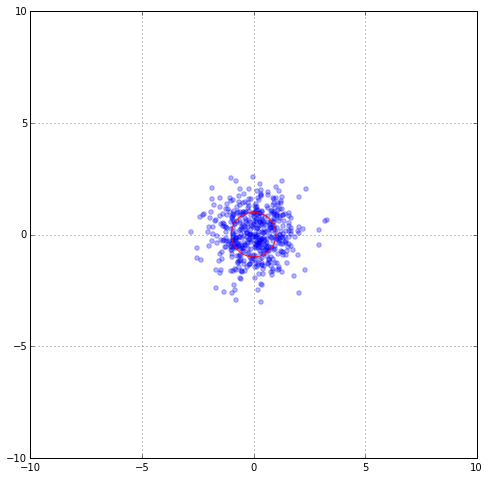

In [54]:
%matplotlib inline
mu = [0, 0]
cov = [[1,0],[0,1]]
x_data, y_data = np.random.multivariate_normal(mu,cov,500).T
#x_data = np.float32(np.random.rand(1,1000))
#y_data = np.float32(np.random.rand(1,1000))
fig = plt.figure(figsize=(8,8))
plt.axis([-10.0,10.0,-10.0,10.0],size=20)
plt.grid(True)
ax = fig.add_subplot(1,1,1)
plot_out = plt.scatter(x_data,y_data,color='b',marker='o',label="$K_2,mu_2$", alpha=0.3)
circle = plt.Circle((0,0),1,color='r', fill=False, alpha=0.9)
plot_out = ax.add_artist(circle)
#plot_out = plt.plot(x_data, y_data, "bo", alpha=0.3, )

#plt.show()

Consider two blue points x and y. The Euclidian distance between x and y is $|| x - y ||_2 = \sqrt{(x-y)^T (x-y)}$. If the data indeed follow the Gaussian, we can naturally use this Euclidan distance to measure the similarity to build the system. However in reality, data are not distributed according to Gaussian, but rather some obscure distribution. Suppose our actual data distribution were something like $\mu = 0$ and Cov = [[3,1], [1, 2]] (, which is still too simplistic for any real data.) Then sample distribution might look like this:  

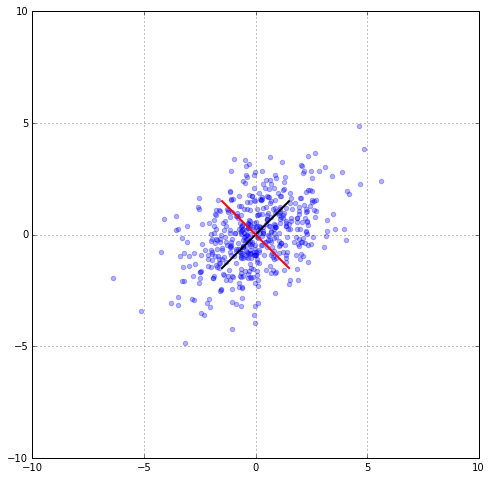

In [16]:
%matplotlib inline
mu = [0, 0]
cov = [[3,1],[1,2]]
x_data, y_data = np.random.multivariate_normal(mu,cov,500).T
#x_data = np.float32(np.random.rand(1,1000))
#y_data = np.float32(np.random.rand(1,1000))
fig = plt.figure(figsize=(8,8))
plt.axis([-10.0,10.0,-10.0,10.0],size=20)
plt.grid(True)
ax = fig.add_subplot(1,1,1)
plt.plot([-1.5, 1.5], [-1.5, 1.5], 'k-', lw=2)
plt.plot([1.5, -1.5], [-1.5, 1.5], 'r-', lw=2)
plot_out = plt.scatter(x_data,y_data,color='b',marker='o',label="$K_2,mu_2$", alpha=0.3)
#circle = plt.Circle((0,0),1,color='r', fill=False, alpha=0.9)
#plot_out = ax.add_artist(circle)


If we simply use the Euclidan distance as a way to measure similarity in this distribution, we could end up with wrong conclusions. For example, the distance measured by the black segment and the distance measured by the red segment are the same in the Euclidian distance and thus we could conclude that the two have the same amount of "face similarity." Suppose, moreover, that we find out, by converting the data points back, that the two faces represented as the points between the red ends are actually less similar than those represented as the points between the black ends.   

Just as we use a z-score as a way to measure the distance from the mean in the case of univariate distributions, we can also think of a similar notion for multivariate distributions. Recall that for univaricate case, $z = \frac{x - \mu}{\sigma}$. Similarly, for multivariate case, $z = L^{-1} (x - \mu)$, where $L$ can be obtained by Choleskly decomposition of the covariance matrix $C$ such that $C = LL^T$. 

So, the Euclidian distance of a point z from the origin in the case of multivariate distributions is $\sqrt{z^Tz}$. If we rewrite this with original variables, we get:
$z^T z = (L^{-1}(x - \mu))^T (L^{-1}(x-\mu)) = (x-\mu) (L^T)^{-1}L^{-1} (x-\mu) = (x-\mu) (LL^T)^{-1} (x-\mu)$
So $\sqrt{z^Tz} = \sqrt{(x-\mu) C^{-1} (x-\mu)}$, which we call Mahalanobis distance.

In the above example, we used $C$ = [[3,1],[1,2]]. So the Mahalanobis distance between points x and y is $|| x - y ||_{C^{-1}} = \sqrt{(x-y)^T C^{-1} (x-y)}$ 

Now let's go back to the paper. In normal settings, we don't have access to C because we don't know the data distribution. What the paper suggests is: why not let the data decide which matrix $C^{-1}$ to use. (We refer $C^{-1}$ as $A$ in the "Simple Answer" section.)  

### Optimization problem

We want to find $A$ so that $d(x,y) = \sqrt{(x-y) A (x-y)}$ encodes the similar-dissimilar information. The simplest formulation would be achieved by restricting those which are similar to have small squared distance, namely : $\min \sum_{x_i, y_i \in S} || x_i - y_i ||^2_A$. However, this would lead to the non-interesting answer which is to let A be 0 matrix, which will also give us 0 for dissimilar pairs of x and y. So we should have another restriction which prevents that to happen. One workaround is to add a constraint on $A$ so that when two points are dissimilar, the squared distance between them be at least bigger than some constant. Namely, $\sum_{x_i, y_i \in D} || x_i - y_i ||_A \ge c$, where $c$ is some positive constant. So the final form is: 
$$ \min_A \sum_{x_i, y_i \in S} || x_i - y_i ||^2_A  \text{ s.t. }  \sum_{x_i, y_i \in D} || x_i - y_i ||_A \ge c \text{ and } A \succeq 0$$

### The case of diagonal A (Sec 2.1 in the paper)

Since A is a diagonal matrix, the constraint $A \succeq 0$ is easy to enforce (just make sure each diagonal element is greater than or equal to 0). By using the log-barrier function to get rid of the inequality constraint, we get the equation described in the paper:

$$\min_A  \sum_{x_i, y_i \in S} || x_i - y_i ||^2_A - \log (\sum_{x_i, y_i \in D} || x_i - y_i ||_A)$$

### The case of full A (Sec 2.2 in the paper)

When A is a full matrix, enforcing $A \succeq 0$ is computationally expensive in the Newton's method framework, so we use projected gradient descent.  